https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com

# Flatiron Phase 5 Project

## Aaron Galbraith

https://www.linkedin.com/in/aarongalbraith \
https://github.com/aarongalbraith

### Submitted: November 20, 2023

## Contents

- **[Business Understanding](#Business-Understanding)<br>**
- **[Data Understanding](#Data-Understanding)**<br>
- **[Data Preparation](#Data-Preparation)**<br>
- **[Exploration](#Exploration)**<br>
- **[Modeling](#Modeling)**<br>
- **[Evaluation](#Evaluation)**<br>
- **[Recommendations](#Recommendations)<br>**
- **[Further Inquiry](#Further-Inquiry)**<br>

# Business Understanding

In 2021 the US Supreme Court ruled in [Dobbs v. Jackson Women's Health Organization](https://www.supremecourt.gov/opinions/21pdf/19-1392_6j37.pdf) that the United States Constitution would no longer confer a right to abortion and that the legality of abortion timelines and procedures would be at the discretion of the individual states. This brought an end to constitutionally enshrined abortion access after Americans had been guaranteed such rights in all American states and territories for roughly two generations, since the 1973 ruling in [Roe v. Wade](https://tile.loc.gov/storage-services/service/ll/usrep/usrep410/usrep410113/usrep410113.pdf). Both immediately and in the two years since Dobbs, [many states have reduced access to abortion, and 14 states have banned abortion entirely](https://reproductiverights.org/maps/abortion-laws-by-state/).

In the new reproductive environment created by this ruling, Americans concerned with family planning need to be better informed of their options. They can learn a lot from one another by comparing their experiences with different treatments. This is especially crucial in communities where birth control practices are discouraged and some young women in particular may be less informed about birth control.

In 2018, researchers Surya Kallumadi and Felix Gräßer at UC Irvine created the [UCI ML Drug Review dataset](https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018/) after collecting reviews from [Drugs.com](https://www.drugs.com/) that users had written about various drugs between 2008 and 2017. A substantial portion of these reviews addressed birth control drugs. Each review was accompanied by a rating left by the user and a tally of how many other users found the review useful ("upvotes").

Our analysis of this data can help inform people about which birth control options are seen by users as the most effective and what side effects are commonly associated with them. We can also use this data to predict what kind of feedback others will find most useful in future conversations. This can help organizations such as Planned Parenthood foster better communication with their clients, both to learn from patients' experiences and to inform patients of their options.

# Data Understanding

## Import files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

import html
import contractions

import re

from IPython.display import display

import seaborn as sns

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from pathlib import Path

SEED = 1979

do_grids = True

## Load and briefly explore data set

In [2]:
d1 = pd.read_csv('../data/drugsComTrain_raw.tsv', delimiter='\t', encoding='latin-1')
d2 = pd.read_csv('../data/drugsComTest_raw.tsv', delimiter='\t', encoding='latin-1')
df = pd.concat([d1,d2]).reset_index().drop(columns=['Unnamed: 0', 'index'])

In [3]:
df.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
df.shape

(215063, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     215063 non-null  object 
 1   condition    213869 non-null  object 
 2   review       215063 non-null  object 
 3   rating       215063 non-null  float64
 4   date         215063 non-null  object 
 5   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 9.8+ MB


There are some missing condition labels.

### `drugName` feature

In [6]:
df.drugName.value_counts()

drugName
Levonorgestrel                       4930
Etonogestrel                         4421
Ethinyl estradiol / norethindrone    3753
Nexplanon                            2892
Ethinyl estradiol / norgestimate     2790
                                     ... 
Melpaque HP                             1
Cortisone                               1
Reyataz                                 1
Striant                                 1
Allergy DN PE                           1
Name: count, Length: 3671, dtype: int64

In [7]:
df.drugName.value_counts().quantile(.90)

120.0

There are 3,671 unique drug names, and 10% of the drug names have more than 120 reviews.

In [8]:
pd.set_option("display.max_rows", None)
print(df.drugName.value_counts())
pd.set_option("display.max_rows", 60)

drugName
Levonorgestrel                                                                                      4930
Etonogestrel                                                                                        4421
Ethinyl estradiol / norethindrone                                                                   3753
Nexplanon                                                                                           2892
Ethinyl estradiol / norgestimate                                                                    2790
Ethinyl estradiol / levonorgestrel                                                                  2503
Phentermine                                                                                         2085
Sertraline                                                                                          1868
Escitalopram                                                                                        1747
Mirena                                        

A casual overview of the drug names indicates that they all seem valid. Some seem to specify drug combinations and/or dosage amounts.

### `condition` feature

In [9]:
df.condition.value_counts()

condition
Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                           1
Sepsis                                              1
105</span> users found this comment helpful.        1
Name: count, Length: 916, dtype: int64

In [10]:
df.condition.value_counts().quantile(.90)

332.5

There are 916 unique conditions, and 10% of the conditions have more than 332 reviews.

In [11]:
pd.set_option("display.max_rows", None)
print(df.condition.value_counts())
pd.set_option("display.max_rows", 60)

condition
Birth Control                                                          38436
Depression                                                             12164
Pain                                                                    8245
Anxiety                                                                 7812
Acne                                                                    7435
Bipolar Disorde                                                         5604
Insomnia                                                                4904
Weight Loss                                                             4857
Obesity                                                                 4757
ADHD                                                                    4509
Diabetes, Type 2                                                        3362
Emergency Contraception                                                 3290
High Blood Pressure                                               

Oddly, the condition labels often (always?) omit initial 'F' and terminal 'r'. We can isolate instances of the former by searching for conditions that start with a lower case letter.

We will eventually trim our records to a number of conditions that Planned Parenthood specializes in treating (and perhaps birth control exclusively), but we will need all the records to help us determine missing condition labels. After we have restored (or discarded) all missing condition labels, we can drop the conditions outside the scope of this review.

### `drugName` × `condition` features

In [12]:
df.groupby('drugName').condition.nunique().value_counts()[:10]

condition
1     1869
2      782
3      334
4      195
5      122
6       83
7       52
8       51
9       38
11      20
Name: count, dtype: int64

This means that, for example, 1869 drugs treat 1 condition only, etc.

In [13]:
df.groupby('condition').drugName.nunique().value_counts()[:10]

drugName
2     188
1     166
4      78
3      72
5      44
7      41
9      34
6      34
10     17
11     16
Name: count, dtype: int64

This means that 188 conditions are treatable by two drugs, etc.

### `review` feature

In [14]:
df.review.nunique()

128478

Comment on number of unique reviews and what this bodes for duplication exploration.

Let's look at several reviews.

In [15]:
for i in range(5):
    print(df.review[i], '\n-----')

"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil" 
-----
"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and so far this is the most effective." 
-----
"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained horm

There appear to be escaped characters (e.g. `&#039;`, indicating an apostrophe) and contractions. We can address this now without affecting our analysis.

We'll reset the review texts to unescape these characters and expand all contractions.

Note: This will replace all instances of `ain't` with `are not`, resulting in some subject-verb agreement issues (e.g. `I are not`). This difference will be negligible in our analysis.

In [16]:
df.review = df.review.apply(lambda x: contractions.fix(html.unescape(x)))

### `rating` feature

In [17]:
df.rating.value_counts()

rating
10.0    68005
9.0     36708
1.0     28918
8.0     25046
7.0     12547
5.0     10723
2.0      9265
3.0      8718
6.0      8462
4.0      6671
Name: count, dtype: int64

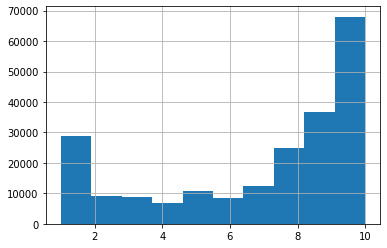

In [18]:
df.rating.hist(bins=df.rating.nunique());

Most of the conditions lie at the extremes, and more of them appear to be at the positive extreme.

### `date` feature

In order to get a better understanding of the `date` feature, we'll convert it to a `datetime` object.

In [19]:
df['datetime'] = df.date.apply(lambda x: datetime.strptime(x, '%B %d, %Y'))

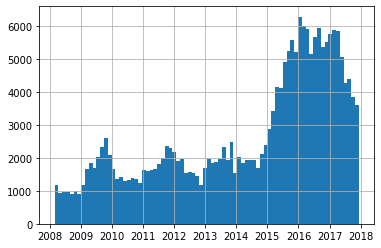

In [20]:
df.datetime.hist(bins=80);

In [21]:
start_date = df.datetime.min().strftime('%B %d, %Y')
end_date = df.datetime.max().strftime('%B %d, %Y')

print('The reviews span specifically from', start_date+',', 'to', end_date+'.')

The reviews span specifically from February 24, 2008, to December 12, 2017.


The reviews began to surge in early 2015.

### `usefulCount` feature

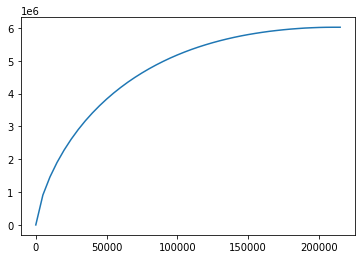

In [22]:
usefulCountCumulative = list(df.usefulCount.values)
usefulCountCumulative.sort(reverse=True)

X = range(0,len(df),5000)
Y = []
for x in X:
    Y.append(sum(usefulCountCumulative[:x]))
fig, ax = plt.subplots()
ax.plot(X,Y);

In [23]:
df.usefulCount.value_counts()[:10]

usefulCount
2    8543
3    8525
0    8402
4    8301
1    8237
5    7844
6    7213
7    6736
8    6271
9    5940
Name: count, dtype: int64

# Data Preparation

## Missing and erroneous condition labels

In this section we will identify all `condition` labels that are either missing or in need of editing.

In [24]:
len(df[df.condition.isna()])

1194

In [25]:
df.condition.fillna('missing', inplace=True)

In [26]:
len(df[df.condition == 'missing'])

1194

We noticed another `condition` label that was meant to indicate missing and should be accordingly changed.

In [27]:
df.condition = df.condition.apply(lambda x: 'missing' if 'Not Listed' in x else x)

In [28]:
len(df[df.condition == 'missing'])

1786

We've identified some actual missing `condition` labels, but we noticed there are more `condition` labels that seem suspicious, particularly ones that start with something other than an upper case character. Let's look at all such `condition` labels.

In [29]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

{'0</span> users found this comment helpful.',
 '100</span> users found this comment helpful.',
 '105</span> users found this comment helpful.',
 '10</span> users found this comment helpful.',
 '110</span> users found this comment helpful.',
 '11</span> users found this comment helpful.',
 '121</span> users found this comment helpful.',
 '123</span> users found this comment helpful.',
 '12</span> users found this comment helpful.',
 '135</span> users found this comment helpful.',
 '13</span> users found this comment helpful.',
 '142</span> users found this comment helpful.',
 '145</span> users found this comment helpful.',
 '146</span> users found this comment helpful.',
 '14</span> users found this comment helpful.',
 '15</span> users found this comment helpful.',
 '16</span> users found this comment helpful.',
 '17</span> users found this comment helpful.',
 '18</span> users found this comment helpful.',
 '19</span> users found this comment helpful.',
 '1</span> users found this comm

These fall into three categories:
1. "X users found this comment helpful" should be regarded as an erroneous label and retagged as "missing.

In [30]:
df.condition = df.condition.apply(lambda x: 'missing' if 'users found' in x else x)

In [31]:
len(df[df.condition == 'missing'])

2957

2. Labels that show a clipped copy of the `drugName` label and end with a parenthesis should also be regarded as missing. These erroneous labels merely repeat information already available in the `drugName` feature.

In [32]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x[-1] in ['(', ')'] \
                                  else x)

In [33]:
len(df[df.condition == 'missing'])

3286

3. Other `condition` labels appear to omit the first and/or last several characters. We can infer certain corrections here to restore many of the conditions.

In [34]:
def condition_restore(condition):
    if condition.split()[-1] in ['Disorde', 'eve', 'Shoulde', 'Cance']:
        condition = condition+'r'
    if condition.split()[0] in ['acial', 'ibrocystic', 'ungal', 'amilial', 'ailure', 'ever', \
                                'emale', 'unctional', 'actor', 'ibromyalgia', 'atigue']:
        condition = 'F'+condition
    if condition.split()[0] in ['llicular', 'llicle', 'lic', 'cal']:
        condition = 'Fo'+condition
    if condition.split()[0] in ['mance']:
        condition = 'Perfor'+condition
    if condition.split()[0] in ['zen']:
        condition = 'Fro'+condition
    if condition.split()[0] in ['mis']:
        condition = 'Dermatitis Herpetifor'+condition
    return condition

df.condition = df.condition.apply(lambda x: condition_restore(x))

Let's look at what we have left.

In [35]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

{'m Pain Disorder', 'me', 't Care', "von Willebrand's Disease"}

"von Willebrand's Disease" appears to be a naturally uncapitalized condition. The others have been impossible to restore and will also be regarded as missing.

In [36]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x.split()[0] != 'von' \
                                  else x)

In [37]:
len(df[df.condition == 'missing'])

3293

We will be able to restore more of these missing condition labels after we do some work with duplicates.

## Duplicates

In [38]:
df.duplicated().value_counts()

False    215061
True          2
Name: count, dtype: int64

In [39]:
df[df.duplicated()]

,drugName,condition,review,rating,date,usefulCount,datetime
178703,Levonorgestrel,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10,2016-09-23
191001,Plan B,Emergency Contraception,"""I had a quickie n he decided to finish it off...",1.0,"September 23, 2016",10,2016-09-23


In [40]:
def show_review(index):
    print(df.review.loc[index])
    display(df[df.review == df.loc[index].review][['drugName', 'condition', 'rating', 'date', 'usefulCount']])

In [41]:
show_review(178703)

"I had a quickie n he decided to finish it off in me... Well IMMEDIATELY we went 2 our local pharmacy n bought this plan b 1 step pill.I took it immediately.2 weeks later,took a pregnancy test n got the world's BIGGEST POSITIVE. The small pill was $50.That was the 1st time in a year n a half that I had intercourse n the last after I had my first son. I honestly believe this pill is ineffective because they just want you to think it works when n reality, it would never work. Alot of women do not know their bodies when they ovulate so if your not fertile and he ejaculates n you and you take the pill n do not get preg., The pill is supposed to make you think it worked. DO NOT buy. Was NEVER effective. Thank you!"


,drugName,condition,rating,date,usefulCount
131531,Levonorgestrel,Emergency Contraception,1.0,"September 23, 2016",10
143768,Plan B,Emergency Contraception,1.0,"September 23, 2016",10
178703,Levonorgestrel,Emergency Contraception,1.0,"September 23, 2016",10
191001,Plan B,Emergency Contraception,1.0,"September 23, 2016",10


For reasons we will explore later, we believe this review was submitted twice by the same person, that each instance of it happened to receive 10 upvotes, and that it should correctly be associated with a grand total of 20 upvotes. Because this is one special instance where the review happened to receive 10 upvotes both times, making it a true duplicate of the data set, we will fix the values here, lest it interfere with operations later on.

In [42]:
df.at[178703, 'usefulCount'] = 20
df.at[191001, 'usefulCount'] = 20
df.drop([131531, 143768], inplace=True)

## Duplicates due to brand / generic pairs

The main type of duplicate we should look out for is records with duplicate reviews, as those likely indicate some kind of actual erroneous duplication. Let's see how many of those there are.

In [43]:
df.duplicated(subset=['review']).value_counts()

False    128467
True      86594
Name: count, dtype: int64

That's a lot!

Let's explore some facets of these duplicates.

In [44]:
len(df[df.duplicated(subset=df.columns.difference(['drugName']))])

85876

The vast majority of duplicate reviews are accounted for by different drug names. Let's explore some examples.

In [45]:
df[df.duplicated(subset=df.columns.difference(['drugName']))].head()

,drugName,condition,review,rating,date,usefulCount,datetime
524,Nexplanon,Birth Control,"""First had implanon then got Nexplanon, had a ...",9.0,"April 21, 2017",5,2017-04-21
574,Cymbalta,Anxiety,"""Prescribed via a Psychiatrist for severe Pani...",1.0,"September 5, 2010",27,2010-09-05
726,Orsythia,Birth Control,"""I have only been on orsythia for about 1 mont...",2.0,"October 8, 2015",7,2015-10-08
1070,Desvenlafaxine,Depression,"""I have suffered from severe anxiety (GAD) and...",8.0,"November 1, 2013",81,2013-11-01
1375,Ethinyl estradiol / norethindrone,Birth Control,"""I have been taking my first pack of Lo Loestr...",8.0,"February 1, 2012",7,2012-02-01


In [46]:
show_review(524)

"First had implanon then got Nexplanon, had a period first month and I have not had one since. I am due to remove it next year.  I do notice spotting  sometimes for a day but it honestly  usually coincides with when I am stressed. 
Had some weight gain also.

So far the best BECAUSE I have  had in all my years.  I plan on trying for a baby next year then I will be back on it."


,drugName,condition,rating,date,usefulCount
374,Etonogestrel,Birth Control,9.0,"April 21, 2017",5
524,Nexplanon,Birth Control,9.0,"April 21, 2017",5


In [47]:
show_review(574)

"Prescribed via a Psychiatrist for severe Panic attacks for 2 years.
If I take dosage late or forget to take it the withdrawal symptoms kick in.  
Gnawing physical pain, breathlessness, disorientation to time, difficulties in word finding while speaking, severe muscle pain and stiffness, nausea, labile emotions and panic.

"


,drugName,condition,rating,date,usefulCount
321,Duloxetine,Anxiety,1.0,"September 5, 2010",27
574,Cymbalta,Anxiety,1.0,"September 5, 2010",27


In [48]:
show_review(726)

"I have only been on orsythia for about 1 month and I just started my second week of my second month.  I guess I did not notice earlier but I started to get slight headaches and I did not feel very well physically and mentally.  It do help with my cramps and my period, not so much my acne but it is better.  The worst part of orsythia has to be the mood swings and the sweating!  I sweat a lot even if it is cold I will start a light sweat, it is gross.  But the mood swings are the worst I just started feeling this and it happened while I was talking to one of my friends I just blew up on him, for no reason.  Then later on I started to feel really bad(mentally) and I cried for a while and I could not figure out why I was crying! I do not recommend!"


,drugName,condition,rating,date,usefulCount
378,Ethinyl estradiol / levonorgestrel,Birth Control,2.0,"October 8, 2015",7
726,Orsythia,Birth Control,2.0,"October 8, 2015",7


In [49]:
show_review(1070)

"I have suffered from severe anxiety (GAD) and was taking more and more Klonopin as time went on.  I am very sensitive to medication and have tried many different SSRI/SNRI's through the year with horrible side effects.  Finally, I had DNA testing to see what I would respond to and the result was Pristiq.  I started it several months ago in a small dose (I split the pills even though they say do not do this) and within a few days my anxiety literally went away.  I was able to cut my Klonopin in 1/2 over a two month period.  The first week or two I was extremely tired but that passed.  The only side effect I get from time to time is migraines.  It still amazes me that my anxiety has disappeared.  I no longer keep Klonopin in my  pocket!"


,drugName,condition,rating,date,usefulCount
855,Pristiq,Depression,8.0,"November 1, 2013",81
1070,Desvenlafaxine,Depression,8.0,"November 1, 2013",81


In [50]:
show_review(1375)

"I have been taking my first pack of Lo Loestrin Fe and I must say it really works for me. I was a little nervous at first because this is my first time taking birth control and I have heard all the negative side effects of taking birth control. I have had spotting [brown-ish color] for three weeks after my period, but that is normal for the first month. I have breast tenderness and mood swings every now and then, then again it is expected for the first few months. I have not yet experienced any weight gain. So far I am satisfied, but I wish it was not so expensive."


,drugName,condition,rating,date,usefulCount
609,Lo Loestrin Fe,Birth Control,8.0,"February 1, 2012",7
1375,Ethinyl estradiol / norethindrone,Birth Control,8.0,"February 1, 2012",7


These five examples make clear that the vast majority of duplicates are due to double-entry; (nearly) every review is entered once with its generic name and once with its brand name.

We can use this phenomenon to restore some of the missing condition labels. If a missing condition label is part of such a unique pair, then we can confidently assign it the condition of its pair-mate.

Let's broaden our search to records that duplicate every feature other than drug name and condition.

In [51]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))])

86221

This is how many records are duplicates of other records in all values EXCEPT (POSSIBLY) drug name and condition. If a record is duplicated in this manner, the second (and third, fourth, etc.) instance will be captured in this bucket of dupes.

If we check only this bucket for dupes, we can see whether there are any triplets, etc.

In [52]:
df_dupes = df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))]

In [53]:
len(df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))])

1

There is only one.

In [54]:
df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))]

,drugName,condition,review,rating,date,usefulCount,datetime
140144,Octreotide,"Diabetes, Type 1","""Great medicine. No side effects.""",9.0,"October 31, 2011",2,2011-10-31


In [55]:
show_review(140144)

"Great medicine. No side effects."


,drugName,condition,rating,date,usefulCount
39512,Reprexain,Pain,7.0,"October 5, 2012",10
60998,Insulin regular,"Diabetes, Type 1",9.0,"October 31, 2011",2
119972,Insulin glulisine,"Diabetes, Type 1",9.0,"October 31, 2011",3
133212,Sandostatin,"Diabetes, Type 1",9.0,"October 31, 2011",2
140144,Octreotide,"Diabetes, Type 1",9.0,"October 31, 2011",2
141100,Insulin isophane / insulin regular,"Diabetes, Type 1",9.0,"October 31, 2011",10
148049,ReliOn / Novolin 70 / 30,"Diabetes, Type 1",9.0,"October 31, 2011",10
184262,Hydrocodone / ibuprofen,Pain,7.0,"October 5, 2012",10


There are 6 records with the same review, date, rating, and condition. (The reviews on October 5, 2012, appear to be just a coincidence of the same review wording for a different drug and condition.) Because they're on the *same day*, it seems likely that these reviews were possibly entered repeatedly by the same person. The two with a useful count of 10 are likely a brand/generic pair.

As for the other 4, it's not clear what is going on. We will (would) later discover that there is also some discrepancy as to which of these is a brand or generic name. Since the review text isn't very descriptive, and the useful count is so low, (and it doesn't pertain to the main conditions treated by Planned Parenthood), let's just drop all 4.

In [56]:
df.drop([60998, 119972, 133212, 140144], inplace=True)

Now we should be able to create a list of pairs of indices of records that match in all features except possibly drug name and condition. To make this run faster, we'll first create a way to sort them by date.

In [57]:
%%time
# ⏰ record the time for this cell -- usually 11-12 s

# create stripped down dataframe that does not have drug names or conditions
# we don't need these features for this operation because we're checking for matches on all other features
df_pairs = df.drop(columns=['drugName', 'condition']).copy()

# create a list of indices of records that duplicate everything other than drug name and condition
df_dupes = df_pairs[df_pairs.duplicated()].index.tolist().copy()

# create and populate a dictionary whose keys are dates and whose values are indices
dates_dict = {}
# populate dictionary with keys that are dates belonging to the duplicates
for date_ in list(set(df[df.index.isin(df_dupes)].date.tolist())):
    dates_dict[date_] = []
# populate dictionary with values that are indices that are NOT from the duplicate list but DO share that date
for i in df[~df.index.isin(df_dupes)].index:
    dates_dict[df.loc[i].date].append(i)

CPU times: user 10.5 s, sys: 43.1 ms, total: 10.6 s
Wall time: 10.6 s


Now we can use this dates dictionary to sort and identify the pairs.

In [58]:
%%time
# ⏰ record the time for this cell -- usually 2–4 mins

# create a list of record pairs where each entry is a list of two indices
pairs = []

# iterate over the indices from the dupes list
for i in df_dupes:
    # set the date to the date from index i
    date_i = df.loc[i].date
    # iterate over OTHER indices who share that date
    for j in dates_dict[date_i]:
        # check for a match
        if df_pairs.loc[i].equals(df_pairs.loc[j]) and df.drugName.loc[i] != df.drugName.loc[j]:
            # remove this index from the dates dictionary so we have fewer to search through in later iterations
            dates_dict[date_i].remove(j)
            # add this pair to the pairs list
            pairs.append([i,j])
            break

CPU times: user 2min 53s, sys: 359 ms, total: 2min 53s
Wall time: 2min 54s


Let's take a look at several of the pairs we've collected.

In [59]:
pairs[:10]

[[524, 374],
 [574, 321],
 [726, 378],
 [1070, 855],
 [1375, 609],
 [1397, 1281],
 [1735, 1043],
 [1965, 299],
 [2014, 1844],
 [2091, 1609]]

Here we'll create a dictionary that matches the index of one pair member to the other member of the pair.

In [60]:
pairs_dict = {}

for pair in pairs:
    for i in range(2):
        pairs_dict[pair[i]] = pair[1-i]

## Restore missing condition labels

We will restore missing condition labels in two ways, in order of certainty:

1. For missing values that possess a pair match, we will assign it the condition of its match.
2. For the remaining missing values, we will assign it the condition that is most commonly associated with its drug name.

In [61]:
len(df[df.condition == 'missing'])

3293

In [62]:
%%time
# ⏰ record the time for this cell -- usually 10-15 seconds

# iterate over each record pair
for pair in pairs:
    # iterate over each member of the pair
    for i in range(2):
        # identify a pair member whose condition is missing
        if df.loc[pair[i]].condition == 'missing':
            # assign to the pair member the condition of its pair-mate
            df.at[pair[i], 'condition'] = df.loc[pairs_dict[pair[i]]].condition

CPU times: user 14 s, sys: 33.5 ms, total: 14.1 s
Wall time: 14.1 s


In [63]:
len(df[df.condition == 'missing'])

2968

Because it will be useful later, we'll make a feature that names the indicated drug and, if applicable, the paired drug.

This is not a *final* replacement for the drug name feature, but it will allow us to better recognize the relationship between the generic and brand drug names.

In [64]:
%%time
# ⏰ record the time for this cell -- usually 15-30 seconds

df['ind'] = df.index

def drugList_fix(index, drugName_):
    drugList = [drugName_]
    if index in pairs_dict:
        drugList.append(df.loc[pairs_dict[index]].drugName)
        # alphabetize each drug pair so that we will not mistakenly duplicate e.g. [A,B] & [B,A]
        drugList.sort()
    return drugList

df['drugList'] = df.apply(lambda x: drugList_fix(x.ind, x.drugName), axis=1)

df.drop(columns='ind', inplace=True)

CPU times: user 18.2 s, sys: 104 ms, total: 18.3 s
Wall time: 18.3 s


Now we can create a feature that tells us if a record is associated with a paired drug name or not.

In [65]:
df['isPaired'] = df.drugList.apply(lambda x: True if len(x) > 1 else False)

In [66]:
len(df[df.isPaired])

172438

In [67]:
len(df[~df.isPaired])

42619

Because lists confuse certain operations

In [68]:
df['drugSetString'] = df.drugList.apply(lambda x: x[0] + ' ' + x[1] if len(x) == 2 else x[0])

In [69]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']))])

86199

With this new feature in place, we can drop one record from each of the brand/generic pairs. The drug name feature will retain only one member of the pair -- unpredictably either the brand or the generic -- which will make this feature more or less useless for the moment.

Before we drop these records, we'll create a bookmark copy of the dataframe.

In [70]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_1 = df.copy()

In [71]:
# df = df_bookmark_1.copy()

In [72]:
df.drop_duplicates(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']), inplace=True)

For every remaining record with a missing condition, we will assign it the condition that is most common for the drug indicated by that record. (This will not be biased by duplicates from brand/generic pairs, because we have dropped those duplicates.)

This will be the last use we have for conditions *not* treated by Planned Parenthood.

In [73]:
drugs_w_missing_condition = list(set(df[df.condition == 'missing'].drugSetString))

In [74]:
len(drugs_w_missing_condition)

678

In [75]:
df.drugSetString.nunique()

3320

This applies to some 20% of the drugs. We'll create a dictionary that reports the most common condition for these drugs.

In [76]:
%%time
# record the time for this cell -- 10-20 seconds

most_common_condition = {}

for drug in drugs_w_missing_condition:
    condition = df[df.drugSetString == drug].condition.value_counts().idxmax()
    if condition == 'missing' and len(set(df[df.drugSetString == drug].condition)) > 1:
        condition = df[(df.drugSetString == drug) &
                       (df.condition != 'missing')
                      ].condition.value_counts().idxmax()
    proportion = round(df[df.drugSetString == drug].condition.value_counts(normalize=True)[0],2)
    most_common_condition[drug] = [condition, proportion]

CPU times: user 11.4 s, sys: 29.8 ms, total: 11.5 s
Wall time: 11.5 s


In [77]:
most_common_condition['Sildenafil Viagra']

['Erectile Dysfunction', 0.87]

For example, if a review with an unlisted condition is about Viagra, we will assume the condition is Erectile 
Dysfunction.

In [78]:
len(df[df.condition == 'missing'])

1799

In [79]:
df['condition'] = df.apply(lambda x: most_common_condition[x.drugSetString][0] \
                           if x.condition == 'missing' \
                           else x.condition, axis = 1)

In [80]:
len(df[df.condition == 'missing'])

27

This is how many records there are that still have no condition label. This means the drugs indicated in these records are *only* indicated in references without an indicated condition. As such, there's not really anything we can do with these records, and we may as well drop them.

In [81]:
df.drop(df[df.condition == 'missing'].index, inplace=True)

In [82]:
len(df[df.condition == 'missing'])

0

## Drop records by condition

At this point, we still have more cleaning to do, but we have identified all the conditions that we can, and we won't have any further need for records with certain condition values, so we'll drop them.

In [83]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_2 = df.copy()

In [220]:
# df = df_bookmark_2.copy()

Let's take another look at the complete list of conditions and choose which ones to keep.

In [221]:
df.condition.nunique()

817

Since there are so many conditions to consider, let's limit this to just conditions with at least 25 reviews.

In [222]:
pd.set_option("display.max_rows", None)
display(df['condition'].value_counts().loc[lambda x: x >= 25])
pd.set_option("display.max_rows", 60)

condition
Birth Control                                                 20054
Depression                                                     7208
Pain                                                           5295
Anxiety                                                        5189
Acne                                                           4571
Insomnia                                                       3471
Bipolar Disorder                                               3333
Weight Loss                                                    3153
Obesity                                                        2780
Vaginal Yeast Infection                                        2648
ADHD                                                           2453
High Blood Pressure                                            2316
Diabetes, Type 2                                               1864
Emergency Contraception                                        1735
Anxiety and Stress                    

In [223]:
df.drop(df[~df.condition.isin(['Birth Control', 'Emergency Contraception'])].index, inplace=True)

In [224]:
df.condition.value_counts()

condition
Birth Control              20054
Emergency Contraception     1735
Name: count, dtype: int64

## Pairing generic and brand names

Now that we have a smaller number of records to deal with, we can sort out generic and brand names.

First we'll create a list of all values from the drug name feature. (Some of these have been dropped from the drug name feature itself when we dropped one record from each brand/generic pair, but all of them were included in the drug list feature.)

We'll create two lists: paired drugs (which we will attempt to sort into brand and generic) and single drugs (each of which we will then try to identify as either brand or generic).

In [225]:
len(df)

21789

In [226]:
all_drug_lists = df.drugList.tolist()
all_drug_lists.sort()

In [227]:
len(all_drug_lists)

21789

In [228]:
all_drug_names = set()

for list_ in all_drug_lists:
    all_drug_names.add(list_[0])
    if len(list_) > 1:
        all_drug_names.add(list_[1])

all_drug_names = list(all_drug_names)

all_drug_names.sort()

In [229]:
len(all_drug_names)

191

In [230]:
# this will create a full list with duplicates
# we need to do this intermediate before moving to the following step to remove duplicates
paired_drug_lists = df[df.isPaired].drugList.tolist()
paired_drug_lists.sort()

In [231]:
len(paired_drug_lists)

20989

In [232]:
paired_drug_names = set()

for pair in paired_drug_lists:
    paired_drug_names.add(pair[0])
    paired_drug_names.add(pair[1])

paired_drug_names = list(paired_drug_names)

paired_drug_names.sort()

In [233]:
unpaired_drug_names = [drug for drug in all_drug_names if drug not in paired_drug_names]

unpaired_drug_names.sort()

In [234]:
len(paired_drug_names)

189

In [235]:
len(unpaired_drug_names)

2

Together, these two lists of names constitute all the drug names left to sort into brand and generic categories.

In order to sort the list of paired drugs into brand and generic, we'll establish a dictionary whose keys are all the drug names that appear in a generic/brand pair.

In [236]:
drug_dict = {}

for drug in paired_drug_names:
    drug_dict[drug] = set()

We'll assign values to those keys according to the pairings. For example, if drug name A is in a generic/brand pair with drug name B, then they will appear on each other's list of values in this dictionary.

In [237]:
for pair in paired_drug_lists:
    drug_dict[pair[0]].add(pair[1])
    drug_dict[pair[1]].add(pair[0])

Let's find out how many of these drug names are associated with exactly one other drug name.

In [238]:
len({drug for drug in drug_dict if len(drug_dict[drug]) == 1})

176

That should mean that exactly the remainder are associated with multiple drug names. It would make sense that drug names that belong to multiple generic/brand pairs are themselves the generic name. On that assumption, we'll create a list of generic drug names.

In [239]:
generics = [drug for drug in drug_dict if len(drug_dict[drug]) > 1]

generics.sort()

In [240]:
len(generics)

13

Now we'll check to make sure that the drug names we've just designated as "generic" do NOT belong to a generic/brand pair with *another* "generic".

In [241]:
count = 0

for drug in generics:
    for match in drug_dict[drug]:
        if match in generics:
            count += 1

print(count)

0


Great.

Then we can begin designating drug names as "brands" if they are in a generic/brand pair with a generic.

In [242]:
brands = set()

for generic in generics:
    for match in drug_dict[generic]:
        brands.add(match)

brands = list(brands)

brands.sort()

In [243]:
len(brands)

166

Now let's see what drugs remain and how many records they are associated with.

In [244]:
uncategorized = list(set(drug for drug in paired_drug_names if drug not in generics and drug not in brands))

uncategorized.sort()

To be clear, these are drug names with the following properties:

- the drug name belongs to an exclusive brand/generic pair
- we have not yet identified which members of the pair are brand and generic

In [245]:
len(uncategorized)

10

We should be able to list all of these drug names in their pairs.

In [246]:
repeated = set()
for drug in uncategorized:
    if drug not in repeated:
        print(drug, '||', list(drug_dict[drug])[0])
        repeated.add(drug)
        repeated.add(list(drug_dict[drug])[0])

Copper || ParaGard
Dienogest / estradiol || Natazia
Ethinyl estradiol / etonogestrel || NuvaRing
Mestranol / norethindrone || Necon 1 / 50
Ulipristal || ella


With so few pairs, we can Google the names to determine which names of a pair are generic and brand names.

In [247]:
# new_brands = [
#     'Clomid', 'Premarin', 'ParaGard', 'Natazia', 'NuvaRing', 'Femara', \
#     'Glucophage', 'Lysteda', 'Megace', 'Necon 1 / 50', 'ella'
# ]

# brands.extend(new_brands)

# len(brands)

In [248]:
new_brands = [
    'ParaGard', 'Natazia', 'NuvaRing', 'Necon 1 / 50', 'ella'
]

brands.extend(new_brands)

len(brands)

171

In [249]:
for drug in new_brands:
    generics.append(list(drug_dict[drug])[0])

len(generics)

18

At this point, we have sorted all the paired brand and generic drug names. What remains is to identify whether each of the single drug names is a generic or brand name.

Let's look at them.

In [250]:
unpaired_drug_names

['Ethinyl estradiol / folic acid / levonorgestrel', 'Nonoxynol 9']

Simple Google search confirms these are both generic names, so we'll add them as such.

In [251]:
generics.extend(unpaired_drug_names)

generics.sort()

Now we create a more universal drug naming system whereby every record is identified with its generic name.

In [252]:
def generic_fix(drugList):
    if len(drugList) == 1 or drugList[0] in generics:
        return drugList[0]
    else:
        return drugList[1]

df['genericName'] = df.drugList.apply(lambda x: generic_fix(x))

In [253]:
def full_brand_fix(drugList):
    if len(drugList) == 1:
        return None
    elif drugList[0] in brands:
        return drugList[0]
    else:
        return drugList[1]

df['fullBrandName'] = df.drugList.apply(lambda x: full_brand_fix(x))

In [254]:
brand_dict = {}

for fullName in brands:
    name = fullName
    tail = name.split()[-1]
    while tail.isnumeric() or tail in ['Fe', 'Lo', 'One-Step', '/', '1.5', 'Contraceptive']:
        name = name[:len(name)-len(tail)-1]
        tail = name.split()[-1]
    head = name.split()[0]
    while head in ['Lo', '/']:
        name = name[len(head)+1:]
        head = name.split()[0]
    brand_dict[fullName] = name

df['shortBrandName'] = df.fullBrandName.apply(lambda x: None if x == None else brand_dict[x])

## Duplicates due to multiple user entry

Now we'll turn to more possible duplicate instances. We suspect the same user has copy-pasted an identical review multiple times when that verbatim review appears for the same condition and (generic) drug name with the same rating. Let's look at all such instances.

In [255]:
len(df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])])

8

In [256]:
df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])] \
[['genericName', 'condition', 'review', 'rating', 'date']]

,genericName,condition,review,rating,date
38469,Levonorgestrel,Emergency Contraception,"""me and my boyfriend were having sex and the c...",10.0,"August 4, 2015"
88315,Ethinyl estradiol / levonorgestrel,Birth Control,"""I have had a great experience on Chateal. I u...",10.0,"August 29, 2016"
97393,Ethinyl estradiol / levonorgestrel,Birth Control,"""I am almost on month 3 of this birth control ...",10.0,"September 22, 2015"
105971,Ethinyl estradiol / norethindrone,Birth Control,"""Was on Junel Fe and it worked according to my...",1.0,"December 6, 2016"
126179,Levonorgestrel,Emergency Contraception,"""Hey gals! In a 'the heat of the moment' situa...",10.0,"June 6, 2015"
129993,Ethinyl estradiol / norgestimate,Birth Control,"""I began taking Mononesse April 28th 2015. I w...",1.0,"October 4, 2015"
155176,Levonorgestrel,Emergency Contraception,"""I, like many others, was having protected sex...",1.0,"July 12, 2015"
193929,Etonogestrel,Birth Control,"""I have recently got my second implant inserte...",8.0,"November 2, 2016"


The review texts all appear to be unique. As long as the review and its duplicate appear close in time to one another (within days), then these should be collapsed into a single review with the respective useful counts added together.

First we'll check on the dates. The following cell will show the respective dates of when these duplicated reviews appeared.

In [257]:
for ind in df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])].index:
    two_indices = list(df[df.review == df.loc[ind].review].index)
    print(df.loc[two_indices[0]].date, '... and ...', df.loc[two_indices[1]].date)

August 4, 2015 ... and ... August 4, 2015
August 29, 2016 ... and ... August 29, 2016
September 22, 2015 ... and ... September 22, 2015
December 6, 2016 ... and ... December 6, 2016
June 6, 2015 ... and ... June 6, 2015
October 4, 2015 ... and ... October 4, 2015
July 12, 2015 ... and ... July 12, 2015
November 3, 2016 ... and ... November 2, 2016


They're all identical dates except one that is a day apart.

We'll collapse these into single records and add the useful counts.

In [258]:
for ind in df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])].index:
    two_indices = list(df[df.review == df.loc[ind].review].index)
    x, y = two_indices[0], two_indices[1]
    count = int(df.loc[x].usefulCount + df.loc[y].usefulCount)
    df.at[x, 'usefulCount'] = count
    df.drop([y], inplace=True)

In [259]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_3 = df.copy()

In [485]:
# df = df_bookmark_3.copy()

## Identifying birth control type

There are various methods of birth control, each with its own advantages and disadvantages. It's important for individuals or couples to consult with a healthcare professional to determine the most suitable method based on their health, preferences, and lifestyle. Here is an overview of different methods of birth control:

1. **Barrier Methods:**
   - **Condoms:** Male and female condoms are physical barriers that prevent sperm from reaching the egg. They also provide protection against sexually transmitted infections (STIs).
   - **Diaphragm and Cervical Cap:** These are devices that are inserted into the vagina to cover the cervix and block sperm.

2. **Hormonal Methods:**
   - **Birth Control Pills:** Oral contraceptives contain hormones (estrogen and/or progestin) that prevent ovulation and alter the cervical mucus to inhibit sperm penetration.
   - **Birth Control Patch:** This is a patch worn on the skin that releases hormones to prevent ovulation.
   - **Birth Control Shot (Depo-Provera):** This is an injection of a progestin hormone that provides protection for three months.
   - **Birth Control Implant (Implanon or Nexplanon):** A small rod implanted under the skin of the upper arm that releases hormones to prevent pregnancy for up to three years.
   - **Vaginal Ring (NuvaRing):** This is a flexible ring inserted into the vagina, releasing hormones to prevent pregnancy.

3. **Intrauterine Devices (IUDs):**
   - **Copper IUD:** A non-hormonal device that is inserted into the uterus and can provide protection for up to 10 years.
   - **Hormonal IUD:** Releases a low dose of progestin and can provide protection for 3-6 years, depending on the type.

4. **Emergency Contraception:**
   - **Emergency Contraceptive Pills (Morning-After Pill):** These pills can be taken after unprotected intercourse to prevent pregnancy. They are most effective when taken as soon as possible but within a specified time frame.

5. **Sterilization:**
   - **Tubal Ligation (for women):** A surgical procedure that involves blocking or sealing the fallopian tubes to prevent eggs from reaching the uterus.
   - **Vasectomy (for men):** A surgical procedure that involves cutting or blocking the vas deferens, preventing sperm from reaching the semen.

6. **Fertility Awareness-Based Methods:**
   - **Natural Family Planning:** Involves tracking menstrual cycles, monitoring body temperature, and observing cervical mucus changes to determine fertile periods.

It's crucial to note that no method is 100% effective, and the effectiveness of each method can be influenced by factors such as consistency of use and individual health. Consultation with a healthcare provider can help determine the most appropriate method for an individual's specific needs and circumstances.

First we'll try to assign methods to all the brand names.

In [486]:
birth_control_dict = {
    'hormonal_IUD': ['Skyla', 'Mirena', 'Kyleena', 'Liletta'],
    'non_hormonal_IUD': ['ParaGard'],
    'patch': ['Ortho Evra', 'Xulane'],
    'implantable': ['Implanon', 'Nexplanon'],
    'vaginal': ['NuvaRing'],
    'injectable': ['Depo-Provera', 'depo-subQ provera', 'Provera'],
    'emergency_pill': ['Plan B', 'ella', 'Fallback Solo', 'Aftera', 'Take Action', 'Next Choice',
                       'My Way', 'EContra EZ'],
    'pill': ['Yasmin', 'Ortho Tri-Cyclen', 'Alesse', 'Aviane', 'Sprintec', 'Tri-Sprintec', 'Mircette',
             'Seasonique', 'Yaz', 'Lutera', 'Portia', 'Camila', 'Apri', 'Beyaz', 'Desogen', 'Kariva',
             'TriNessa', 'Zarah', 'Estarylla', 'Mononessa', 'Gianvi', 'Jolivette', 'Loestrin', 'Microgestin',
             'Ortho-Cyclen', 'Ortho-Novum', 'Necon', 'Femcon', 'Marlissa', 'Aubra', 'Viorele', 'Vestura',
             'Norlyda', 'Ortho Cyclen', 'Lybrel', 'Pirmella', 'Larin', 'Tarina', 'Previfem', 'Tri-Estarylla',
             'Lessina', 'Elinest', 'Cryselle', 'Ortho-Cept', 'Falmina', 'Altavera', 'Tri-Lo-Marzia', 'Taytulla',
             'CamreseLo', 'Philith', 'Dasetta', 'Gildess', 'Ovral', 'Jencycla', 'Tri-Linyah', 'Enskyce',
             'Orsythia', 'Sronyx', 'Velivet', 'Reclipsen', 'Nikki', 'Levlen', 'Loryna', 'Juleber', 'Trivora',
             'Zenchent', 'Tri-Previfem', 'Lyza', 'Seasonale', 'Mono-Linyah', 'Alyacen', 'Opcicon']
}

In [487]:
def method_fix_1(shortBrandName):
    for method in birth_control_dict:
        if shortBrandName in birth_control_dict[method]:
            return method
    else:
        return None

df['method'] = df.shortBrandName.apply(lambda x: None if x == None else method_fix_1(x))

In [488]:
generic_dict = {
    'patch': ['Ethinyl estradiol / norelgestromin'],
    'non_hormonal_IUD': ['Copper'],
    'implantable': ['Etonogestrel'],
    'emergency_pill': ['Ulipristal'],
    'vaginal': ['Ethinyl estradiol / etonogestrel'],
    'pill': ['Ethinyl estradiol / levonorgestrel',
             'Drospirenone / ethinyl estradiol / levomefolate calcium',  'Mestranol / norethindrone',
             'Ethinyl estradiol / norgestimate', 'Ethinyl estradiol / norethindrone',
             'Norethindrone', 'Drospirenone / ethinyl estradiol', 'Desogestrel / ethinyl estradiol',
             'Ethinyl estradiol / norgestrel', 'Ethinyl estradiol / folic acid / levonorgestrel',
             'Ethinyl estradiol / ethynodiol', 'Dienogest / estradiol'],
    'hormonal_IUD': [],
    'injectable': ['Medroxyprogesterone']
}

In [489]:
def method_fix_2(generic):
    for method in generic_dict:
        if generic in generic_dict[method]:
            return method
    else:
        return None

df['method'] = df.apply(lambda x: method_fix_2(x.genericName) if x.method == None else x.method, axis=1)

In [490]:
df[
    (df.method.isna())
].genericName.value_counts()

genericName
Levonorgestrel    173
Nonoxynol 9         2
Name: count, dtype: int64

In [492]:
for ind in df[df.genericName == 'Nonoxynol 9'].index:
    show_review(ind)

"I have a 44 year old daughter that is proof that Delfen Foam is not effective."


,drugName,condition,rating,date,usefulCount
172606,Nonoxynol 9,Birth Control,1.0,"May 25, 2016",2


"This was and is still a  nightmare contraceptive.  Bought this and used with my boyfriend. Used 3 in one night.  We both had side effects.  We are exclusive if not. ..I would have thought I caught something.  Felt good after using but 2 hours later the excess is flowing out & leaves me feeling slightly irritated.  I wash again but still feel a persistent irritation. Day 2. he had a weird sensation while peeing.  Both of us have itchy genitals and it only gets worse from there.  I almost feel like a yeast infection.  My anal region itches.my vaginal area feels dry but it is not.  It is just highly irritated.  I have used raw yogurt, acidophilus pulls and so feel irritated.  Never using this again. It is day 4 and these symptoms are still annoying"


,drugName,condition,rating,date,usefulCount
209857,Nonoxynol 9,Birth Control,9.0,"April 29, 2015",5


In [493]:
generic_dict['spermicide'] = ['Nonoxynol 9']

In [494]:
for ind in df[
    (df.genericName == 'Levonorgestrel') &
    (df.method.isna())
].index[:10]:
    show_review(ind)

"My girlfriend and I had sex during her fertile period, the condom broke and we did not realize. She took the pill around 8 hours later and it worked, she got her period! I have read in some journals that the pill may not work during the fertile period so be careful! Anyhow for us worked :)"


,drugName,condition,rating,date,usefulCount
585,Levonorgestrel,Emergency Contraception,10.0,"March 15, 2017",0


"I NEVER write reviews but today I decided to because when I was looking through all the reviews here it really helped me. so I am going to pay it back and hope to help someone else .... I have never taken this pill before, never really had to but there is always a first time for everything ! So, I took it about 3 hours after my bf finished inside of me . I was freaking out !! I freaked out everyday until today when I finally got my period .. I had sex 9/10, and was supposed to get my period 9/26, I got it 9/25. No side effects except mild nausea , and cramps all the way until today ! But it worked. So let us thank God and all these people that work making these drugs for us !  Hope i could help someone with this review"


,drugName,condition,rating,date,usefulCount
1151,Levonorgestrel,Emergency Contraception,10.0,"September 26, 2016",1


"I am 255lbs/5'1 height and 33 years old. I say this because I read many reviews and doctor's explanation that the pill sometimes does not work on obese or overweight people. It worked for me. I took it within 4 hours of being intimate with my boyfriend. You feel like you are pregnant because for at least 5 days I felt like activity was going on in my uterus, and the day before my period arrived I had really bad cramps, when I have not had cramps since I was in high school, at 120lbs and a size 2. Yes, it throws off your period. I was not due to have my period for another 2.5 weeks. However, my period came 7 days after being intimate and taking the pill, immediately. So, it works! You might be a little paranoid and feel like your pregnant because of cramps and what feels like activity going on in your uterus, but it works!"


,drugName,condition,rating,date,usefulCount
1741,Levonorgestrel,Emergency Contraception,10.0,"November 16, 2016",0


"My boyfriend and I had sex on 1/11/14 and the condom fell off. Around 1 hours later I took the morning after pill and I am happy to say that I got my period today 3 days sooner! (This was also around the time the calendar said I was ovulating) so do not freak out! As long as you take it as soon as possible you will be fine!"


,drugName,condition,rating,date,usefulCount
2298,Levonorgestrel,Emergency Contraception,10.0,"January 28, 2014",46


"I took the emergency contraception pill almost 5 days before my ovulation. I took it within 3 hours of the mishap with the condom. I was worried sick thinking I could be pregnant. My period was meant to come on a Monday, but it came on Sunday, which was 6 days late. I was so scared, I nearly cried, but I did end up getting my period. I am so relieved. All that stress did not help. If you have taken the Emergency Cobtraceptive Pill, do not worry if your period is a bit delayed."


,drugName,condition,rating,date,usefulCount
5925,Levonorgestrel,Emergency Contraception,10.0,"January 25, 2015",8


"I took the pill at the beginning of December. My boyfriend and I had been using protection but we both felt like something was different one day so I went and got the pill. I got my period one day earlier than normal almost three weeks later. We were both happy and not worried until I was supposed to start my period in January. We were both very stressed because I had been cramping yet I was more than a week late.  One day we were going to go get a pregnancy test but I started my period at school. My period has become much heavier and I have worse cramps than before. Still I was very happy to get my period. So do not worry if you are a couple days late."


,drugName,condition,rating,date,usefulCount
6509,Levonorgestrel,Emergency Contraception,10.0,"January 28, 2012",1


"Took this pill at about 40 hrs post said accident. We are now pregnant. As I am a mother to two, we were not planning on anymore kids and are extremely careful. We have taken plan B in the past and I guess we should have this time as well."


,drugName,condition,rating,date,usefulCount
7825,Levonorgestrel,Emergency Contraception,1.0,"December 24, 2016",0


"Hi I promised that if it worked I would write a review here. I had sex the day after my period (April 25) and I took it just an hour later, he did not ejaculate inside me but it was unprotected and there was precum. I took 4 pills of levonorgestrel in the morning then 4 again 12 hours later. My period was supposed to come May 16 but it was late by 11 days. Levo will really mess up your cycle and give you sore breasts, mood swings and everything that might make you pregnant. Take a pregnancy test 21 days after sex and then again a week after! Do not worry girls, just stick to the facts and get it as soon as possible before your ovulation (it might not work after). 10/10! Stay safe and do not make decisions about sex without staying protected."


,drugName,condition,rating,date,usefulCount
7870,Levonorgestrel,Emergency Contraception,10.0,"May 28, 2017",0


"My boyfriend and I had one too many drinks and we decided to have unprotected sex without using the pull out method! Well, I took the pill about 10 hours after for my very first time. I had no major side effects after taking the pill. After an hour or two of taking the pill I became very sleepy. I had my time of month a week earlier, and I was more hormonal than usual. I did not imagine the pill being a little expensive but I rate it a 10 because it worked and it is sure worth the cost."


,drugName,condition,rating,date,usefulCount
10671,Levonorgestrel,Emergency Contraception,10.0,"September 19, 2015",5


"On June 5 at midnight, My boyfriend & I fooled around without a condom on my fertile days he did not finish or anything or put it all the way in but getting pregnant through even some pre cum is possible just unlikely. Just to be safe I took one around 10am on June 7 because I already have a 4 month old. I feel okay. A little dizzy , cramps nauseous, not anything crazy. I am sure it will go well. Hoping I can avoid taking it again though! Will post another experience about when my period comes this month!"


,drugName,condition,rating,date,usefulCount
11447,Levonorgestrel,Emergency Contraception,5.0,"June 7, 2015",0


All of these examples describe emergency contraception.

In [495]:
generic_dict['pill'].append('Levonorgestrel')
df['method'] = df.apply(lambda x: method_fix_2(x.genericName) if x.method == None else x.method, axis=1)

In [496]:
df[
    (df.method.isna())
].genericName.value_counts()

Series([], Name: count, dtype: int64)

# Exploration

explore each feature vs. rating and each feature vs. useful

explore rating vs. useful

explore high and low rating vs. useful

explore topic modeling

In [504]:
df.method.value_counts()

method
pill                10069
implantable          4412
hormonal_IUD         2900
emergency_pill       1569
vaginal               829
non_hormonal_IUD      801
injectable            690
patch                 509
spermicide              2
Name: count, dtype: int64

In [534]:
# a function that takes a list of tweets and 1) tokenizes them, 2) lemmatizes them, and 3) removes stopwords
def make_tokens(reviews, stop_list=stop_list):
    # make list of tokens
    tokens = nltk.word_tokenize(','.join(reviews))
    return tokens
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    # stop tokens
    tokens_stopped = [word for word in tokens_lemmatized if \
                      word not in stop_list]
    return tokens_stopped

In [535]:
# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list = stopwords.words('english')
# add punctuation characters
for char in string.punctuation:
    stop_list.append(char)
# add empty string
stop_list.extend([''])

In [536]:
# stop words to keep
# 44-59 be/have/do verbs
# 64-178 prepositions/subordinate conjunctions/modals
stop_list = stop_list[:44] + stop_list[60:64]

In [537]:
df['review_lower'] = df['review'].str.lower()

In [538]:
pill_tokens = make_tokens(df[df.method == 'pill'].review_lower.tolist(), stop_list=stop_list)

In [544]:
implantable_tokens = make_tokens(df[df.method == 'implantable'].review_lower.tolist(), stop_list=stop_list)

In [540]:
# a function that generates a word cloud of a given list of words
def make_wordcloud(wordlist, colormap='Greens', title=None):
    # instantiate wordcloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        colormap=colormap,
        collocations = True
    )
    return wordcloud.generate(','.join(wordlist))

In [541]:
# a function that plots the word cloud
def plot_wordcloud(wordcloud):
    # plot wordcloud
    plt.figure(figsize = (12, 15)) 
    plt.imshow(wordcloud) 
    plt.axis('off');

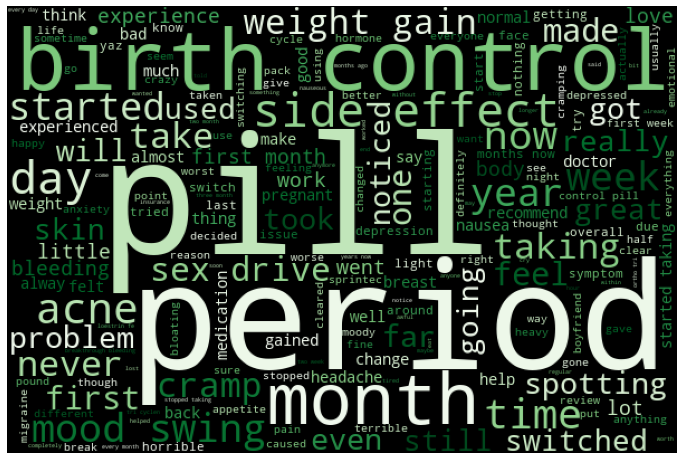

In [543]:
plot_wordcloud(make_wordcloud(pill_tokens))

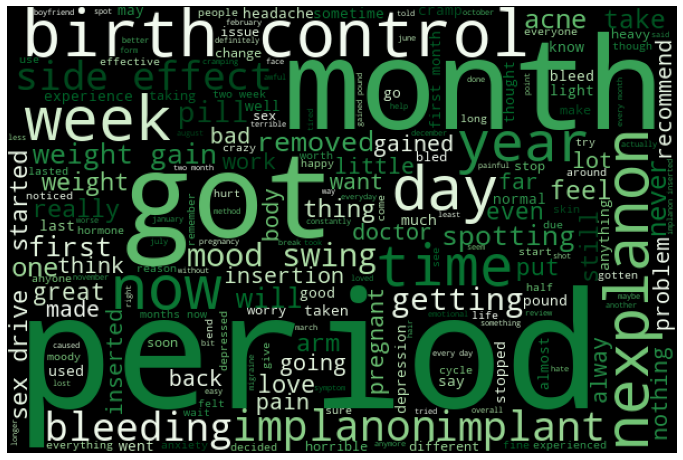

In [545]:
plot_wordcloud(make_wordcloud(implantable_tokens))

In [499]:
df.groupby('method').genericName.nunique()

method
emergency_pill       2
hormonal_IUD         1
implantable          1
injectable           1
non_hormonal_IUD     1
patch                1
pill                13
spermicide           1
vaginal              1
Name: genericName, dtype: int64

In [502]:
df.groupby('method').shortBrandName.nunique()

method
emergency_pill        8
hormonal_IUD          4
implantable           2
injectable            3
non_hormonal_IUD      1
patch                 2
pill                117
spermicide            0
vaginal               1
Name: shortBrandName, dtype: int64

In [510]:
df.groupby('method').rating.mean()

method
emergency_pill      8.505417
hormonal_IUD        7.024483
implantable         5.826609
injectable          5.552174
non_hormonal_IUD    7.111111
patch               6.793713
pill                5.806634
spermicide          5.000000
vaginal             6.641737
Name: rating, dtype: float64

In [509]:
df.groupby('method').usefulCount.mean()

method
emergency_pill      14.351816
hormonal_IUD         8.343103
implantable          6.771079
injectable           7.942029
non_hormonal_IUD     7.590512
patch                9.235756
pill                 7.678915
spermicide           3.500000
vaginal              8.726176
Name: usefulCount, dtype: float64

# exploration of rating and useful count

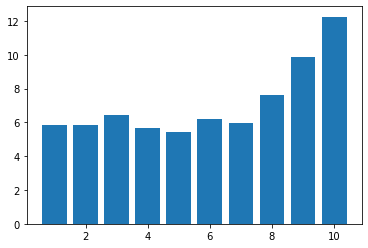

In [511]:
X = range(1,11)
Y = []
for x in X:
    Y.append(df[df.rating == x].usefulCount.mean())
fig, ax = plt.subplots()
ax.bar(X,Y);

This shows the average useful count by rating from 1 to 10. It seems that ratings of 8 and above are considered more useful than the others.

In [512]:
threshold = 20

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

2% of the reviews received 20% of all the upvotes.
This includes reviews with 41 or more upvotes


In [514]:
df[df.usefulCount >= 41].rating.value_counts(normalize=True)

rating
10.0    0.479638
9.0     0.208145
8.0     0.065611
1.0     0.056561
3.0     0.052036
5.0     0.031674
2.0     0.031674
6.0     0.031674
7.0     0.029412
4.0     0.013575
Name: proportion, dtype: float64

In [515]:
threshold = 40

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

8% of the reviews received 40% of all the upvotes.
This includes reviews with 20 or more upvotes


In [516]:
df[df.usefulCount >= 20].rating.value_counts(normalize=True)

rating
10.0    0.434662
9.0     0.212071
8.0     0.095238
1.0     0.063123
3.0     0.035991
7.0     0.034884
5.0     0.034330
6.0     0.030454
2.0     0.029900
4.0     0.029347
Name: proportion, dtype: float64

In [517]:
threshold = 60

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

19% of the reviews received 60% of all the upvotes.
This includes reviews with 11 or more upvotes


In [518]:
df[df.usefulCount >= 11].rating.value_counts(normalize=True)

rating
10.0    0.369976
9.0     0.205518
8.0     0.098197
1.0     0.083207
3.0     0.043667
7.0     0.043450
5.0     0.043015
2.0     0.039757
6.0     0.037367
4.0     0.035846
Name: proportion, dtype: float64

In [519]:
threshold = 80

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

38% of the reviews received 80% of all the upvotes.
This includes reviews with 6 or more upvotes


In [520]:
df[df.usefulCount >= 6].rating.value_counts(normalize=True)

rating
10.0    0.310422
9.0     0.175387
1.0     0.118301
8.0     0.106651
2.0     0.054438
5.0     0.053908
7.0     0.051154
3.0     0.050943
6.0     0.039504
4.0     0.039293
Name: proportion, dtype: float64

In [521]:
threshold = 95

uv = list(df.usefulCount.values)
uv.sort(reverse=True)
n = 0
while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
    n += 1
print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
print('This includes reviews with', uv[n], 'or more upvotes')

65% of the reviews received 95% of all the upvotes.
This includes reviews with 3 or more upvotes


In [522]:
df[df.usefulCount >= 3].rating.value_counts(normalize=True)

rating
10.0    0.266525
9.0     0.159120
1.0     0.139362
8.0     0.103361
2.0     0.063780
5.0     0.061526
3.0     0.060731
7.0     0.057018
4.0     0.046145
6.0     0.042432
Name: proportion, dtype: float64

In [ ]:
X = range(0,len(df),100)
Y = []
for x in X:
    Y.append(sum(uv[:x]))
fig, ax = plt.subplots()
ax.plot(X,Y);

This shows the cumulative sum of upvotes. For example, if we go 5% of the reviews in from the left on the x-axis, we would reach up to 33% of the total upvotes on the y-axis.

# feature engineering ideas

- word count
- character count
- words in all caps
- average word length
- whether words are in English (spelled correctly)
- whether it includes characters such as exclamation points, question marks, (especially repeatedly), and emoticons
- whether it mentions the brand or generic name in the review
- whether it uses slang versus technical language
- whether it mentions touchy subjects such as abortion
- ngrams

In [ ]:
engineered_features = []

In [ ]:
df['raw_tokens'] = df.review.apply(lambda x: nltk.word_tokenize(x))

In [ ]:
df['review_lower'] = df['review'].str.lower()

In [ ]:
def plot_useful(feature, low=0.15, high=0.85):
    X = range(int(df[feature].quantile(low)), int(df[feature].quantile(high)))
    Y = []
    for x in X:
        Y.append(df[df[feature] == x].usefulCount.mean())
    fig, ax = plt.subplots()
    ax.plot(X,Y);

# all caps words

In [ ]:
def all_caps_fix(tokens_list):
    count = 0
    for token in tokens_list:
        if len(token) > 2 and token.isupper():
            count += 1
    return count

df['all_caps'] = df.raw_tokens.apply(lambda x: all_caps_fix(x))

In [ ]:
df.all_caps.value_counts()[:10]

In [ ]:
plot_useful('all_caps', high=0.99)

In [ ]:
engineered_features.append('all_caps')

# no caps usage

In [ ]:
df['no_caps'] = df.apply(lambda x: 1 if x.review == x.review_lower else 0, axis=1)

In [ ]:
df.no_caps.value_counts()

In [ ]:
df[df.no_caps == 1].usefulCount.mean()

In [ ]:
df[df.no_caps == 0].usefulCount.mean()

In [ ]:
engineered_features.append('no_caps')

# exclaim count

In [ ]:
df['exclaim_count'] = df.raw_tokens.apply(lambda x: x.count('!'))

In [ ]:
df.exclaim_count.value_counts()[:10]

In [ ]:
plot_useful('exclaim_count', high=0.995)

In [ ]:
engineered_features.append('exclaim_count')

# question count

In [ ]:
df['question_count'] = df.raw_tokens.apply(lambda x: x.count('?'))

In [ ]:
df.question_count.value_counts()

In [ ]:
plot_useful('question_count', low=0.01, high=0.999)

In [ ]:
engineered_features.append('question_count')

# word count

In [ ]:
df['word_count'] = df.raw_tokens.apply(lambda x: len(x))

In [ ]:
plot_useful('word_count')

In [ ]:
engineered_features.append('word_count')

# character count

In [ ]:
df['character_count'] = df.review.apply(lambda x: len(x))

In [ ]:
plot_useful('character_count')

In [ ]:
engineered_features.append('character_count')

# characters per word

In [ ]:
df['cpw'] = 100 * df.character_count / df.word_count

In [ ]:
df.cpw.value_counts()

In [ ]:
plot_useful('cpw', low=0.01, high=0.99)

In [ ]:
engineered_features.append('cpw')

# age disclosure

In [ ]:
def age_disclosure_feature(review):
    if re.search('[1-4][0-9] +y(ea)?rs? +(old|of age)', review) or \
    re.search('(pregnant( +at)?|age( +of)?|being) +[1-4][0-9]', review) or \
    re.search('(teen|ty|one|two|three|four|five|six|seven|eight|nine) +y(ea)?rs? +(old|of +age)', review) or \
    re.search('i +(am +|was +|will +be +|would have been +)(not even +)?(now +)?(only +)?(just +)?(maybe +)?[1-4][0-9](\s|\.|\!|\?)', review):
        return True
    else:
        return False

df['age_disclosure'] = df.review_lower.apply(lambda x: 1 if age_disclosure_feature(x) else 0)

In [ ]:
df.age_disclosure.value_counts()

In [ ]:
df[df.age_disclosure == 1].usefulCount.mean()

In [ ]:
df[df.age_disclosure == 0].usefulCount.mean()

In [ ]:
engineered_features.append('age_disclosure')

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_4 = df.copy()

In [ ]:
# df = df_bookmark_4.copy()

# functions

# separate pos / neg

In [ ]:
df_neg = df[df.rating < 4]

In [ ]:
df_neg.shape

In [ ]:
neg_reviews = df_neg.review.tolist()

In [ ]:
lemmatizer = WordNetLemmatizer()

neg_tokens = make_tokens(neg_reviews)

In [ ]:
ff = ["me", 'you', 'th"ey', 'we', "we"]

In [ ]:
barf = ['"', "I've", 'tried', 'a', 'few']

In [ ]:
def make_wordcloud(wordlist, colormap='Greens', title=None):
    # instantiate wordcloud
    wordcloud = WordCloud(
        width=600,
        height=400,
        colormap=colormap,
        collocations = True
    )
    return wordcloud.generate(','.join(wordlist))

def plot_wordcloud(wordcloud):
    # plot wordcloud
    plt.figure(figsize = (12, 15)) 
    plt.imshow(wordcloud) 
    plt.axis('off');

In [ ]:
plot_wordcloud(make_wordcloud(ff))

In [ ]:
uv = list(df_neg.usefulCount.values)
uv.sort(reverse=True)

In [ ]:
X = range(0,len(df_neg),50)
Y = []
for x in X:
    Y.append(sum(uv[:x]))
fig, ax = plt.subplots()
ax.plot(X,Y);

## Results function

We'll create a function that takes the pipeline we've created and displays only the results we're interested in.

In [ ]:
def model_results(pipeline):
    # fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    # generate predictions for the test data
    y_pred = pipeline.predict(X_test)
    # display the training and test accuracy scores
    print(f"Training Score: {round(pipeline.score(X_train, y_train),4)} \
    \nTest Score:     {round(pipeline.score(X_test, y_test),4)}")
    
    # plot the normalized confusion matrix
    plot_confusion_matrix(estimator=pipeline, X=X_test, y_true=y_test, cmap='Greens', 
                          normalize='true', 
                          display_labels=['Non-positive', 'Positive'])

# save and reload preprocessed set

At this stage we will save and reload the preprocessed set in order to avoid taking the time to repeat earlier work everytime we open the notebook.

The saved version has restored or deleted all records with missing condition labels.

We have established pairs in the list `twins` but we have NOT yet deleted either member of any pair or dealt with the confusion between brand and generic drug names.

The size of the dateframe is nearly the same as its original version, roughly 215,000 records.

In the future, store the functions with this?

Store the engineered features list.

In [ ]:
filepath = Path('../data/preprocessed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

In [ ]:
%store engineered_features

In [ ]:
df = pd.read_csv('../data/preprocessed.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
%store -r engineered_features

# Modeling

I'll carefully put the pieces together one cell at a time. If it all works, I can combine them later.

* define target feature using thresholds

In [ ]:
useful_threshold = [1, 12]

print(len(df[df.usefulCount <= useful_threshold[0]]), len(df[df.usefulCount >= useful_threshold[1]]))

In [ ]:
df.drop(df[
    (df.usefulCount > useful_threshold[0]) & \
    (df.usefulCount < useful_threshold[1])
].index, inplace=True)

df['target'] = df.usefulCount.apply(lambda x: 1 if x >= useful_threshold[1] else 0)

In [ ]:
X_train, X_test, y_train, y_test = \
train_test_split(df[['review'] + engineered_features], df['target'], test_size=0.2, random_state=SEED)

In [ ]:
# save this value to compare to future model crossval scores
plurality_cv = round(y_train.value_counts(normalize=True)[1],4)
# show the sentiment breakdown
round(y_train.value_counts(normalize=True),4)

----------------------------------

In [ ]:
# reset variables

text_preprocessor = None
numerical_preprocessor = None
preprocessor = None
pipeline = None
accuracy = None
feature_names = None
coefficients = None
decision_function_values = None
importance_df = None
feature_importance = None

In [ ]:
# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list = stopwords.words('english')
# add punctuation characters
# for char in string.punctuation:
#     stop_list.append(char)
# add empty string
# stop_list.extend([''])

In [ ]:
# stop words to keep
# 44-59 be/have/do verbs
# 64-178 prepositions/subordinate conjunctions/modals
stop_list = stop_list[:44] + stop_list[60:64]

In [ ]:
# variables of interest

max_features = None
stop_words = stop_list
ngram_range = (2,4)
model = LogisticRegression(max_iter=1000)
# model = SVC(kernel='linear')
# model = MultinomialNB() # does not work
# model = GaussianNB() # does not work
# model = DecisionTreeClassifier(random_state=SEED)
# model = BaggingClassifier()
# model = RandomForestClassifier(random_state=SEED)
# model = AdaBoostClassifier(random_state=SEED)
# model = GradientBoostingClassifier(random_state=SEED)
# model = XGBClassifier(random_state=SEED)
n_features = 25
title = '_____ Model'

In [ ]:
text_preprocessor = TfidfVectorizer(
    max_features=max_features,
    stop_words=stop_words,
    ngram_range=ngram_range
)

In [ ]:
numerical_preprocessor = StandardScaler()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_preprocessor, 'review'),
        ('numerical', numerical_preprocessor, engineered_features)
    ]
)

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [ ]:
%%time
pipeline.fit(X_train, y_train);

In [ ]:
accuracy = pipeline.score(X_test, y_test)

In [ ]:
print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
feature_names = preprocessor.named_transformers_['text'].get_feature_names_out().tolist() + engineered_features

In [ ]:
# the success of this code seems to depend on whether we feed it a dense or sparse matrix
# supposedly the .ravel() method will handle either

# this works for SVC, LogisticRegression

# --------------------------------------------------------
if hasattr(model, 'feature_importances_'):
    coefficients = model.feature_importances_
elif hasattr(model.coef_, 'toarray'):
    coefficients = model.coef_.toarray().flatten()
else:
    coefficients = model.coef_.flatten()
# --------------------------------------------------------

# this works for DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier
# seems meaningless in the case of AdaBoost

# --------------------------------------------------------
# coefficients = model.feature_importances_
# --------------------------------------------------------

# this works for BaggingClassifier
# (but it might not mean anything?)

# --------------------------------------------------------
# coefficients = np.mean([
#     tree.feature_importances_ for tree in model.estimators_
# ], axis=0)
# --------------------------------------------------------

# coefficients = model.coef_.toarray().flatten()  # Assuming sparse matrix

# coefficients = model.coef_.flatten()  # Assuming dense matrix

# coefficients = model.coef_.ravel()  # should work for dense or sparse matrix

# try:
#     # Try to access coef_ (only available for linear kernels)
#     coefficients = model.coef_.flatten()
# except AttributeError:
#     # Handle the case for non-linear kernels
#     decision_function_values = pipeline.decision_function(X_train)
#     coefficients = (preprocessor.transform(X_train).T @ decision_function_values * y_train).sum(axis=1)

In [ ]:
importance_df = pd.DataFrame(feature_names, columns=['Word'])
importance_df['Importance'] = np.e**(abs(coefficients))
importance_df['Coefficient'] = coefficients

In [ ]:
feature_importance = importance_df.sort_values(
    by = ["Importance"], ascending=False
).head(n_features)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10), ncols=2)
ax[0].set_title(f'Coefficients for {title}')
ax[0].set_ylabel('Word')
ax[0].set_xlabel('Coefficient')
sns.barplot(x='Coefficient', y='Word', data=feature_importance, 
            palette='coolwarm', ax=ax[0])
#plotting feature importances
ax[1].set_title(f'Feature Importances for {title}')
ax[1].set_ylabel('Word')
ax[1].set_xlabel('Importance')
sns.barplot(x='Importance', y='Word', data=feature_importance, 
            palette='coolwarm', ax=ax[1])
plt.tight_layout();

# Evaluation

# Recommendations

# Further Inquiry